# Training a video classification model


### Step 1: Dataset
 1. Save data in a more efficient format for reading
 2. Write a Dataset for the converted videos. Given an index, return a N frame 'clip' from the video
 
 i.e. 
 
Video1 is 25 frames, Video2 is 100 frames. N = 10. 


Index 3 gives Video1 frames [3-13)

Index 15 gives Video1 frames [15-25)

Index 16 gives Video2 frames [0-10)

A useful formula: The number of N frame 'clips' in a M frame video = M-N+1

### Step 2: Model

### Step 3: Training

In [10]:
import torch
from torch import nn 
import torchvision
import glob
from tqdm.notebook import tqdm
from torchsummary import summary # pip install torchsummary
import matplotlib.pyplot as plt

In [4]:
path_to_videos = r"C:\Users\willc\Downloads\val_rgb_front_clips\raw_videos"
path_to_new_videos = r"C:\Users\willc\Downloads\val_rgb_front_clips\processed"

In [5]:
# Ignore this cell. It is useful operations that are not available in all versions of PyTorch
from torchvision.transforms import RandomResizedCrop
def _is_tensor_video_clip(clip):
    if not torch.is_tensor(clip):
        raise TypeError("clip should be Tesnor. Got %s" % type(clip))

    if not clip.ndimension() == 4:
        raise ValueError("clip should be 4D. Got %dD" % clip.dim())

    return True
def crop(clip, i, j, h, w):
    """
    Args:
        clip (torch.tensor): Video clip to be cropped. Size is (C, T, H, W)
    """
    assert len(clip.size()) == 4, "clip should be a 4D tensor"
    return clip[..., i:i + h, j:j + w]


def resize(clip, target_size, interpolation_mode):
    assert len(target_size) == 2, "target size should be tuple (height, width)"
    return torch.nn.functional.interpolate(
        clip, size=target_size, mode=interpolation_mode
    )
def resized_crop(clip, i, j, h, w, size, interpolation_mode="bilinear"):
    """
    Do spatial cropping and resizing to the video clip
    Args:
        clip (torch.tensor): Video clip to be cropped. Size is (C, T, H, W)
        i (int): i in (i,j) i.e coordinates of the upper left corner.
        j (int): j in (i,j) i.e coordinates of the upper left corner.
        h (int): Height of the cropped region.
        w (int): Width of the cropped region.
        size (tuple(int, int)): height and width of resized clip
    Returns:
        clip (torch.tensor): Resized and cropped clip. Size is (C, T, H, W)
    """
    assert _is_tensor_video_clip(clip), "clip should be a 4D torch.tensor"
    clip = crop(clip, i, j, h, w)
    print(clip.shape)
    clip = resize(clip, size, interpolation_mode)
    print(clip.shape)
    return clip
def normalize(clip, mean, std, inplace=False):
    """
    Args:
        clip (torch.tensor): Video clip to be normalized. Size is (C, T, H, W)
        mean (tuple): pixel RGB mean. Size is (3)
        std (tuple): pixel standard deviation. Size is (3)
    Returns:
        normalized clip (torch.tensor): Size is (C, T, H, W)
    """
    assert _is_tensor_video_clip(clip), "clip should be a 4D torch.tensor"
    if not inplace:
        clip = clip.clone()
    mean = torch.as_tensor(mean, dtype=clip.dtype, device=clip.device)
    std = torch.as_tensor(std, dtype=clip.dtype, device=clip.device)
    clip.sub_(mean[:, None, None, None]).div_(std[:, None, None, None])
    return clip
class RandomResizedCropVideo(RandomResizedCrop):
    def __init__(
        self,
        size,
        scale=(0.08, 1.0),
        ratio=(3.0 / 4.0, 4.0 / 3.0),
        interpolation_mode="bilinear",
    ):
        if isinstance(size, tuple):
            assert len(size) == 2, "size should be tuple (height, width)"
            self.size = size
        else:
            self.size = (size, size)

        self.interpolation_mode = interpolation_mode
        self.scale = scale
        self.ratio = ratio

    def __call__(self, clip):
        """
        Args:
            clip (torch.tensor): Video clip to be cropped. Size is (C, T, H, W)
        Returns:
            torch.tensor: randomly cropped/resized video clip.
                size is (C, T, H, W)
        """
        i, j, h, w = self.get_params(clip, self.scale, self.ratio)
        j = 280  # center the crop
        return resized_crop(clip, i, j, h, w, self.size, self.interpolation_mode)

    def __repr__(self):
        return self.__class__.__name__ + \
            '(size={0}, interpolation_mode={1}, scale={2}, ratio={3})'.format(
                self.size, self.interpolation_mode, self.scale, self.ratio
            )
class NormalizeVideo(object):
    """
    Normalize the video clip by mean subtraction and division by standard deviation
    Args:
        mean (3-tuple): pixel RGB mean
        std (3-tuple): pixel RGB standard deviation
        inplace (boolean): whether do in-place normalization
    """

    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, clip):
        """
        Args:
            clip (torch.tensor): video clip to be normalized. Size is (C, T, H, W)
        """
        return normalize(clip, self.mean, self.std, self.inplace)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, inplace={2})'.format(
            self.mean, self.std, self.inplace)


In [18]:
frames = []
for file in glob.glob(r"C:\Users\willc\Downloads\val_rgb_front_clips\raw_videos\*"):
    tmp = torchvision.io.read_video(file)
    print(tmp.shape)
#     frames.append(tmp.shape[1])
    

ImportError: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.


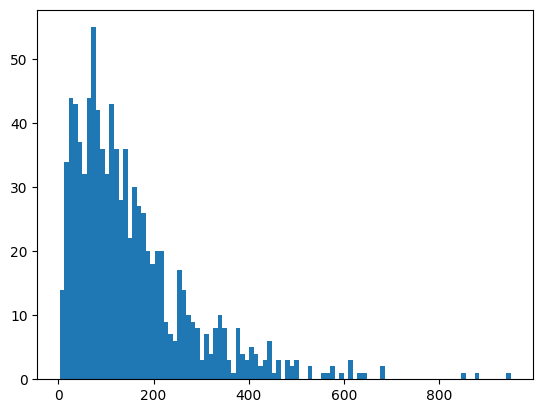

In [14]:
_ = plt.hist(frames, bins=100)

In [ ]:
# WARNING: This takes up a LOT of space (>100GB). Feel free to skip this step. If you do, just make sure you 
# use the resize_fn below on your data (I'll have a comment showing where)
norm_fn = NormalizeVideo( [0.485, 0.456, 0.406],  [0.229, 0.224, 0.225])
resize_fn =  RandomResizedCropVideo(
        224, 
        scale=(1.0,1.0), # use whole image
        ratio=(1.0, 1.0) # crop center square
    )

# This will take a while

for video_path in tqdm(glob.glob(path_to_videos + "\*")):
    video_root = video_path.split("\\")[-1] 
    video_data, audio_data, metadata = torchvision.io.read_video(video_path)
    frames, h, w, c = video_data.shape
    video_data = video_data.permute([3,0,1,2]).float()/255 # THWC -> CTHW
    video = norm_fn(video_data)
    video = resize_fn(video)

    new_path = path_to_new_videos + "\\" + video_root.split('.')[0] + ".pt"
    torch.save(video, new_path)
    

  0%|          | 0/1739 [00:00<?, ?it/s]

torch.Size([3, 189, 720, 720])
torch.Size([3, 189, 224, 224])
torch.Size([3, 32, 720, 720])
torch.Size([3, 32, 224, 224])
torch.Size([3, 172, 720, 720])
torch.Size([3, 172, 224, 224])
torch.Size([3, 42, 720, 720])
torch.Size([3, 42, 224, 224])
torch.Size([3, 82, 720, 720])
torch.Size([3, 82, 224, 224])
torch.Size([3, 140, 720, 720])
torch.Size([3, 140, 224, 224])
torch.Size([3, 111, 720, 720])
torch.Size([3, 111, 224, 224])
torch.Size([3, 43, 720, 720])
torch.Size([3, 43, 224, 224])
torch.Size([3, 199, 720, 720])
torch.Size([3, 199, 224, 224])
torch.Size([3, 174, 720, 720])
torch.Size([3, 174, 224, 224])
torch.Size([3, 89, 720, 720])
torch.Size([3, 89, 224, 224])
torch.Size([3, 68, 720, 720])
torch.Size([3, 68, 224, 224])
torch.Size([3, 165, 720, 720])
torch.Size([3, 165, 224, 224])
torch.Size([3, 63, 720, 720])
torch.Size([3, 63, 224, 224])
torch.Size([3, 100, 720, 720])
torch.Size([3, 100, 224, 224])
torch.Size([3, 90, 720, 720])
torch.Size([3, 90, 224, 224])
torch.Size([3, 120, 720,

In [ ]:
clip_length = 30
class How2SignDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_videos, clip_length):
        self.video_root = path_to_videos
        self.clip_length = clip_length
        
        # Get list of paths to all videos
        list_of_all_videos = glob.glob(path_to_videos+"\*")
        
        # Get their corresponding labels
        self.list_of_all_video_ids = [x.split("//")[-1].split("_")[0] for x in list_of_all_videos]
        self.unique_video_ids = set(self.list_of_all_video_ids)
        # Calculate how many clips you have
        # Recall that the number of N frames clips in an M frame video: # = M-N+1
        # N = clip_length
        # M = number of frames in a video
        
        # We want to sum across all videos
        # What happens if M<N? 
            # You can choose how to handle this. I recommend 0-padding in the __getitem__ function.
            # More information on how to do this in the __getitem__ function
        total_clips = 0
        for video in list_of_all_videos:
            # TODO 
            pass
        self.length = total_clips
        
        # TODO:
        # This is not trivial, think through the process
        # When we retrieve some index with the __getitem__, we need to know which video path and label the index corresponds to
        # This is not equal to the index of the video/label, since one video might have many examples
        
        # Additionally, we need our index to correspond to a unique slice of that video. 
        # You need to add some method of keeping track of this
        
        # I recommend creating a list with self.length entries
        # Each entry is a tuple of (video_path, label, starting_frame)
        

    def __len__(self):
        return len(self.length)
    def __getitem__(self, idx):
        # Retrieve the correct clip and label
        video, label = None, None
        
        # If you didn't process videos, you should process your videos here:
        
        # These can go in the __init__ 
        # self.norm_fn = NormalizeVideo( [0.485, 0.456, 0.406],  [0.229, 0.224, 0.225])
        # self.resize_fn = RandomResizedCropVideo(
        #         224, 
        #         scale=(1.0,1.0), # use whole image
        #         ratio=(1.0, 1.0) # crop center square
        #     )
        
        # These should go here
        # video_data = video_data.permute([3,0,1,2]).float()/255
        # video_data = self.resize_fn(self.norm_fn(video_data))
        
        # What happens if M<N? 
            # 1. Check if this is the case (if the number of frames in the video < self.clip_length)
            # If True, one solution is to pad the video to end with 0s 
                # video = torch.zeros(3, self.clip_length, 224, 224)
                # video[:, :num_frames, :, :] = video_data
            # if False, no problem
                # video = video_data[:, start_frame:start_frame + self.clip_length]
        
        # You should return video, label such that:
        # video.shape = C, T, H, W = 3, self.clip_length, 224, 224
        # label should be a single integer representing the INDEX that the label corresponds to 
                # (use self.list_of_all_video_ids.index('string'))
            
        
        return video, label
        
dataset = How2SignDataset(path)     

## Next: Create a Model

In [ ]:
# Useful Layers:

# Conv3D 
# MaxPool3D (if you only want to reduce spatial resolution and not temporal, use a kernel with width 1 in time dim)
    # torch.nn.MaxPool3d((2,2,2)) # takes the max of a 2x2x2 area. Shape BCTHW becomes BC(T/2)(H/2)(W/2)
    # torch.nn.MaxPool3d((1,3,2)) # Takes the max of a 1x3x2 area. Shape BCTHW becomes BCT(H/3)(W/2)
# BatchNorm3D
    # Normalizes our data with mean 0 standard deviation 1. 
    # Helps with learning, reduces 'internal covariate shift'
    # If I forgot to talk about this remind me
# ReLU
    # Or some other non-linearity
    
# Recommended design
    # Use 5 'stages', where each stage ends with a maxpool
    # Inside each stage, repeat a 'Convolutional Block' N times.
        # A Convolutional Block generally consists of: Conv, BatchNorm, ReLU or Conv, ReLU, BatchNorm
    # Generally, each stage will have the same number of channels
    
# Visual Explaination:
    # Stage1
        # Block1
            # Conv, 32 channels
            # ReLU
            # BatchNorm
    # Maxpool
    # Stage 2
        # Block1
            # Conv, 64 channels
            # ReLU
            # BatchNorm
        # Block2
            # Conv, 64 channels
            # ReLU
            # BatchNorm
    # ... 
    
# At the end of your model:
    # 1. Flatten your data
        # B, C, T, H, W -> B, C*T*H*W 
        # Use .flatten(start_dim=1)
    # 2. Use Linear layer(s)
        # torch.nn.Linear(input_features, output_features)
        # i.e. self.fc1= nn.Linear(C*T*H*W, hidden_dim1)
        # ... self.fcN = nn.Linear(hidden_dimN, num_classes)
    # 3. Don't forget to ReLU between stages
    # 4. Dropout is also useful
    # 5. Finally, make sure to Softmax before returning 
         # so that each entry is a probability of that class
    


In [ ]:
class VideoClassifier(nn.Module):
    def __init__(self, num_classes=None):
        super(VideoClassifier, self).__init__()
        # TODO add layers
        
        
    def forward(self, x):
        # X.shape = B, C, T, H, W = B, 3, num
        # TODO add layers
        return x
    
model = VideoClassifier(num_classes=len(dataset.unique_video_ids))

In [ ]:
# quick test of the model
model(torch.rand(4, 3, clip_length, 224, 224))

In [ ]:
# model summary
summary(model, (3, clip_length, 224, 224))

## Next, train our model

In [ ]:
batch_size = # TODO choose batch size
lr = # TODO choose learning rate
loss_fn = # TODO (which loss should we use for multilass classification?)
opt = # TODO choose an optimizer: https://pytorch.org/docs/stable/optim.html

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)


In [ ]:
for epoch in range(1): # TODO what is an epoch?
    for x, y in train_dataloader:
        # TODO zero gradients
        # TODO pass input through model (perform forward pass)
        # TODO calculate loss
        # TODO calculate gradients (perform backward pass)
        # TODO apply gradients (with your optimizer)
        break # we'll just do one sample since they take a while
    break